# Cross-correlation between STG and dPCC electrodes

- cross correlation during speech and non-speech fragments
- t-test

In [2]:
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from utils import load_fragment_times, cross_correlate

%matplotlib inline

In [8]:
hdir = '..'
speech = load_fragment_times(hdir, 'speech')
nonspeech = load_fragment_times(hdir,'nonspeech')
a = np.load('../data/audio_envelope_100Hz.npy')

In [6]:
subj = 's1'
x    = np.load('../data/' + subj + '_HD_100Hz_hfb.npy')
pm = np.load('../results/ttest_ecog_speech_nonspeech_'+subj+'_pmask.npz')['pmask_bonf'] # pmask from the first ttest
grid = np.load('../data/' + subj + '_HD_grid.npy')
n = x.shape[-1]

In [10]:
r_spe, r_non = [], []
for spe_frag, non_frag in zip(speech, nonspeech):
    r_spe.append([])
    r_non.append([])
    for e in [15]: # stg electrodes (#15 is best, matlab index 16)
        r_spe[-1].append([])
        r_non[-1].append([])
        for i in range(x.shape[-1]):
            r_spe[-1][-1].append(
                cross_correlate(x[spe_frag[0]:spe_frag[1], i], x[spe_frag[0]:spe_frag[1], e], type='spearman'))
            r_non[-1][-1].append(
                cross_correlate(x[non_frag[0]:non_frag[1], i], x[non_frag[0]:non_frag[1], e], type='spearman'))

r_spe, r_non = np.array(r_spe), np.array(r_non)

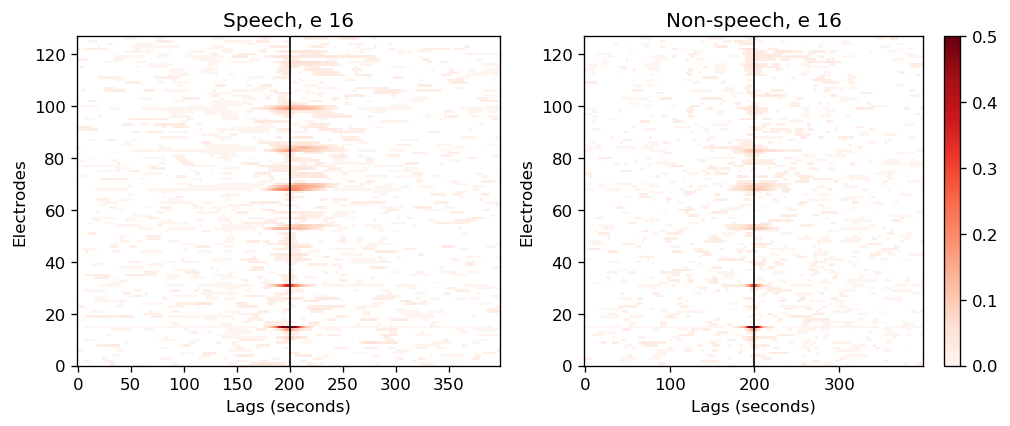

In [15]:
cmap = mpl.cm.get_cmap('Reds')
cmap.set_bad((1, 1, 1))
d = np.mean(r_spe, 0)[0][:, 200:-200].copy()
d[np.abs(d) < .015] = np.nan
plt.figure(figsize=(10, 8), dpi=120)
plt.subplot(221)
plt.imshow(d, aspect='auto', vmin=0, vmax=.5, cmap=cmap)
plt.plot([200, 200], [0, x.shape[-1]], 'k', linewidth=1)
plt.ylim(0, x.shape[-1] - 1)
plt.title('Speech, e 16')
plt.xlabel('Lags (seconds)')
plt.ylabel('Electrodes')

d = np.mean(r_non, 0)[0][:, 200:-200].copy()
d[np.abs(d) < .015] = np.nan
plt.subplot(222)
plt.imshow(d, aspect='auto', vmin=0, vmax=.5, cmap=cmap)
plt.plot([200, 200], [0, x.shape[-1]], 'k', linewidth=1)
plt.ylim(0, x.shape[-1] - 1)
plt.title('Non-speech, e 16')
plt.xlabel('Lags (seconds)')
plt.ylabel('Electrodes')
plt.colorbar()
plt.show()

In [16]:
# take max correlation within [-100:500] ms per fragment
e = 0
r_spe_m = np.max(r_spe[:, e, :,390:-349], 2)
r_non_m = np.max(r_non[:, e, :,390:-349], 2)

In [17]:
# fisher transform
r_spe_mf = np.arctanh(r_spe_m)
r_non_mf = np.arctanh(r_non_m)

/home/julia/Documents/Python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in arctanh
  
/home/julia/Documents/Python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arctanh
  
/home/julia/Documents/Python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until
/home/julia/Documents/Python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# t-test on speech vs non-speech fragments
ts, ps = [], []
for i, j in zip(r_spe_mf.T, r_non_mf.T):
    t, p = ttest_ind(i, j)
    ts.append(t)
    ps.append(p)
ts, ps = np.array(ts), np.array(ps)
ts_masked = ts.copy()


ts_masked[15] = np.inf
ps[15] = 0

/home/julia/Documents/Python/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/julia/Documents/Python/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3851: RuntimeWarning: invalid value encountered in double_scalars
  d = mean1 - mean2


In [19]:
# significance
thresh_05 = 5e-2/pm.shape[0]
thresh_01 = 1e-2/pm.shape[0]
len(ts_masked[pm][ps[pm]<thresh_05])
ts_masked[np.setdiff1d(range(n), pm)] = 0
ts_masked[ps >= thresh_05] = 0

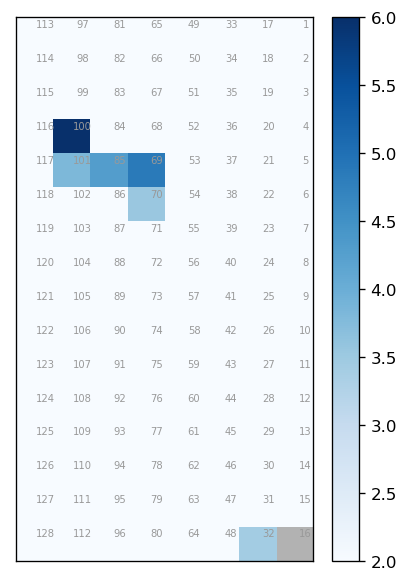

In [20]:
# plot for s1
plt.figure(figsize=(4, 6), dpi=120)
cmap = plt.get_cmap('Blues')
cmap.set_bad((.7, .7, .7))
plt.imshow(ts_masked[grid], aspect='auto', cmap = cmap, vmin = 2, vmax = 6, extent=[0, grid.shape[-1], 0, grid.shape[0]])
for (i, j), k in np.ndenumerate(np.flipud(grid)):
    plt.gca().text(j+.8, i+.8, k+1, ha='center', va='center', color=(.6, .6, .6), fontsize=6)
plt.xticks([])
plt.yticks([])
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.colorbar()
plt.show()